In [1]:
# auto reload
%load_ext autoreload
%autoreload 2

In [2]:
# import bc stuff
import os
import pickle
import argparse
import torch
import torch.nn as nn

import tree
from acme import wrappers
from dm_control import suite

from src.environment import NormilizeActionSpecWrapper, MujocoActionNormalizer
from src.bc_net import BCNetworkContinuous, BCNetworkContinuousGaussian
from src.sac import GaussianPolicy
from src.bc_utils import evaluate_network_mujoco



In [7]:
# constants:

rollout_path = '../../data/rollouts/cheetah_123456_10000_actnoise080/rollouts.pkl'
lr = 3e-4
epochs = 10
batch_size = 16

In [8]:
env = suite.load(domain_name="cheetah", task_name="run")

env = NormilizeActionSpecWrapper(env)
env = MujocoActionNormalizer(environment=env, rescale='clip')
env = wrappers.SinglePrecisionWrapper(env)

In [9]:
# get the dimensionality of the observation_spec after flattening
flat_obs = tree.flatten(env.observation_spec())
# combine all the shapes
obs_dim = sum([item.shape[0] for item in flat_obs])

# load the rollouts
with open(rollout_path, 'rb') as f:
    rollouts = pickle.load(f)

In [17]:
# initialize the network
# network = BCNetworkContinuousGaussian(obs_dim, env.action_spec().shape[0])

network = GaussianPolicy(obs_dim, env.action_spec().shape[0], hidden_dim=256)

# define the optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=lr)

# define the loss function for reparmetrization trick
mse_loss_fn = nn.MSELoss()

# define the number of epochs
num_epochs = epochs

# define the batch size
batch_size = batch_size

# define the number of batches
num_batches = len(rollouts.obs) // batch_size

# convert the data to tensors
obs = torch.tensor(rollouts.obs, dtype=torch.float32).squeeze()
action = torch.tensor(rollouts.action, dtype=torch.float32).squeeze()

In [18]:
# define the scaling factors
MSE_SCALING = 1
KL_SCALING = 0.25

In [ ]:
# train the network with reparametrization trick
for epoch in range(num_epochs):
    epoch_mse_loss_arr = []
    epoch_kl_div_arr = []
    epoch_loss_arr = []

    for batch in range(num_batches):
        # get the batch
        batch_obs = obs[batch * batch_size:(batch + 1) * batch_size]
        batch_action = action[batch * batch_size:(batch + 1) * batch_size]

        # print(batch_obs.shape)

        # sample from the network
        sampled_action, log_prob, mean = network.sample(batch_obs)

        # compute the mse loss
        mse_loss = mse_loss_fn(sampled_action, batch_action)

        # compute the kl divergence
        kl_div = torch.mean(log_prob)  # - torch.mean(torch.log(1 - action.pow(2) + 1e-6))

        # compute the loss
        loss = mse_loss*MSE_SCALING + kl_div*KL_SCALING

        # backpropagate the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log the losses
        epoch_mse_loss_arr.append(mse_loss.item())
        epoch_kl_div_arr.append(kl_div.item())
        epoch_loss_arr.append(loss.item())

    # print the loss
    print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')

Epoch: 1, Loss: -0.1992
Epoch: 2, Loss: -0.2544


In [13]:
epoch_mse_loss_arr

[0.9212455153465271,
 0.9620203375816345,
 1.418226718902588,
 1.271363377571106,
 1.5510965585708618,
 1.0690826177597046,
 1.6116825342178345,
 1.3037033081054688,
 1.785593032836914,
 0.689384937286377,
 1.6335134506225586,
 1.1977075338363647,
 1.3163901567459106,
 1.6629315614700317,
 1.2262870073318481,
 2.135402202606201,
 1.3346439599990845,
 1.3854039907455444,
 1.4613970518112183,
 1.6199640035629272,
 1.232279896736145,
 1.7609237432479858,
 0.8056188225746155,
 1.4908536672592163,
 1.1795364618301392,
 1.6129788160324097,
 1.8229130506515503,
 1.1821683645248413,
 1.46731698513031,
 1.9811040163040161,
 0.7933675646781921,
 1.7680867910385132,
 1.300887942314148,
 1.3973146677017212,
 1.5441975593566895,
 0.8883863091468811,
 1.8488683700561523,
 1.4306780099868774,
 1.9173823595046997,
 0.7536250948905945,
 2.0833616256713867,
 1.141321063041687,
 1.4031000137329102,
 1.3805861473083496,
 1.104676604270935,
 1.7254810333251953,
 0.7296112179756165,
 1.947741985321045,
 0.9

In [14]:
epoch_kl_div_arr

[-197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.37942504882812,
 -197.3794

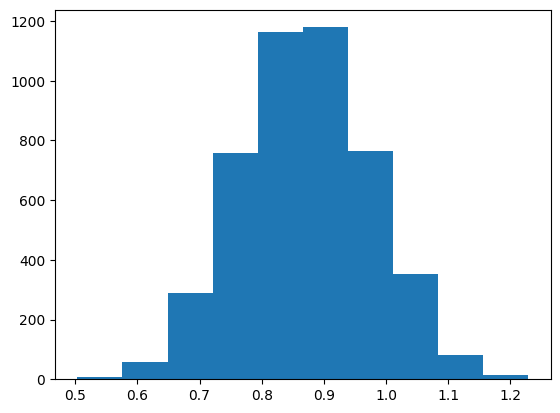

In [15]:
# plot the distribution of the mse_loss
import matplotlib.pyplot as plt
plt.hist(epoch_mse_loss_arr)
plt.show()

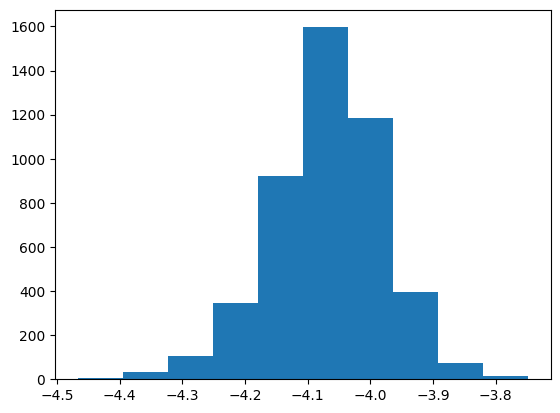

In [16]:
# plot the distribution of the kl_div
plt.hist(epoch_kl_div_arr)
plt.show()


In [ ]:
# plot the distribution of the